In [1]:
import functools
from pynx.scattering import fhkl as fhkl_module

print("Applying definitive monkey patch to pynx.scattering.fhkl.GPUThreads...")

# Import the GPU libraries to check for their availability
try:
    import pycuda.driver as drv
    drv.init()
except Exception:
    drv = None

try:
    import pyopencl as cl
except Exception:
    cl = None

# Store the original __init__ method before we replace it
original_GPUThreads_init = fhkl_module.GPUThreads.__init__

def find_best_gpu_backend():
    """Finds the best available GPU, prioritizing CUDA, and returns its configuration."""
    if drv and drv.Device.count() > 0:
        gpu_name = drv.Device(0).name().decode('utf-8')
        return {'language': 'CUDA', 'gpu_name': gpu_name, 'cl_platform': ''}
    if cl:
        platforms = cl.get_platforms()
        for platform in sorted(platforms, key=lambda p: 'intel' in p.name.lower()):
            try:
                gpu_devices = platform.get_devices(device_type=cl.device_type.GPU)
                if gpu_devices:
                    gpu_name = gpu_devices[0].name
                    return {'language': 'OpenCL', 'gpu_name': gpu_name, 'cl_platform': platform.name}
            except cl.Error:
                continue
    raise RuntimeError("Monkey-patch could not find any suitable CUDA or OpenCL GPU.")

# --- The Wrapper that Correctly Forces the GPU ---
class GpuInfo:
    # Store the discovered config so we only search once.
    config = None

@functools.wraps(original_GPUThreads_init)
def patched_GPUThreads_init(self, gpu_name="", language="", cl_platform="", nbCPUthread=None, verbose=False):
    """
    Patched __init__ for the GPUThreads class. It intercepts generic or CPU-bound
    calls and forces them to use the best available GPU.
    """
    # Discover the best GPU backend only on the first call
    if GpuInfo.config is None:
        GpuInfo.config = find_best_gpu_backend()
        print(f"Monkey-patch: Found best GPU backend: {GpuInfo.config}")

    # Check if the call is generic, unspecified, or explicitly for the CPU
    is_generic_or_cpu_call = gpu_name.lower() in ['', 'gpu', 'cpu'] or language.lower() in ['', 'cpu']

    if is_generic_or_cpu_call:
        print(f"Monkey-patch: Intercepted generic call. Forcing backend to: {GpuInfo.config}")
        # Override the parameters with our discovered best GPU
        language = GpuInfo.config['language']
        gpu_name = GpuInfo.config['gpu_name']
        cl_platform = GpuInfo.config.get('cl_platform', '')

    # Call the original __init__ method with the corrected parameters
    original_GPUThreads_init(self, gpu_name=gpu_name, language=language, cl_platform=cl_platform,
                             nbCPUthread=nbCPUthread, verbose=verbose)

# --- Apply the patch ---
fhkl_module.GPUThreads.__init__ = patched_GPUThreads_init
print("✅ pynx hardware selection is now patched to prioritize GPUs.")

Applying definitive monkey patch to pynx.scattering.fhkl.GPUThreads...
✅ pynx hardware selection is now patched to prioritize GPUs.


In [2]:
import numpy as np
import pynx.scattering.fhkl
import time

# Safely import the required GPU libraries
try:
    import pycuda.driver as drv
    import pycuda.compiler as compiler
except ImportError:
    drv, compiler = None, None
try:
    import pyopencl as cl
except ImportError:
    cl = None

print("Applying high-performance monkey patch to pynx.scattering.fhkl...")

# ==============================================================================
# ===== 1. DEFINE THE PATCH FOR THE OpenCLThread_Fhkl.run METHOD =============
# ==============================================================================
def patched_opencl_run(self):
    ctx = cl.Context([self.dev])
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    CL_prg_fhkl, CL_kernel_fhkl = None, None
    self.block_size = 64
    if self.dev.max_work_group_size < self.block_size: self.block_size = self.dev.max_work_group_size
    kernel_params = {"block_size": self.block_size}
    options = "-cl-mad-enable -cl-fast-relaxed-math"
    self.context_init = True
    while True:
        self.eventStart.wait()
        if self.join_flag: break
        t0 = time.time()
        natoms, nhkl = self.x.size, self.h.size
        self.fhkl_real = np.zeros_like(self.h); self.fhkl_imag = np.zeros_like(self.h)

        # MINIMAL FIX: Only change the step_atoms calculation to prevent overflow.
        step_atoms = max(self.block_size, (128 * 1024 * 1024) // (3 * self.x.itemsize) // self.block_size * self.block_size)
        steps_nbatoms = list(range(0, natoms, step_atoms))
        
        if not steps_nbatoms or steps_nbatoms[-1] != natoms: steps_nbatoms.append(natoms)
        steps_nhkl = list(range(0, nhkl, 65535 * self.block_size))
        if not steps_nhkl or steps_nhkl[-1] != nhkl: steps_nhkl.append(nhkl)

        for j in range(1, len(steps_nhkl)):
            h_chunk, k_chunk, l_chunk = self.h[steps_nhkl[j-1]:steps_nhkl[j]], self.k[steps_nhkl[j-1]:steps_nhkl[j]], self.l[steps_nhkl[j-1]:steps_nhkl[j]]
            fhkl_real_ = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=np.zeros_like(h_chunk, dtype=np.float32))
            fhkl_imag_ = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=np.zeros_like(h_chunk, dtype=np.float32))
            h_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_chunk)
            k_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=k_chunk)
            l_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=l_chunk)
            
            for i in range(1, len(steps_nbatoms)):
                tmpx, tmpy, tmpz = self.x[steps_nbatoms[i-1]:steps_nbatoms[i]], self.y[steps_nbatoms[i-1]:steps_nbatoms[i]], self.z[steps_nbatoms[i-1]:steps_nbatoms[i]]
                x_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpx)
                y_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpy)
                z_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpz)
                if self.occ is None and self.vkzi is None:
                    if CL_prg_fhkl is None:
                        CL_prg_fhkl = cl.Program(ctx, pynx.scattering.fhkl.CL_FHKL_CODE % kernel_params).build(options=options)
                        CL_kernel_fhkl = cl.Kernel(CL_prg_fhkl, "Fhkl")
                    event = CL_kernel_fhkl(queue, (h_chunk.size, 1), (self.block_size, 1), fhkl_real_, fhkl_imag_, x_, y_, z_, np.int64(tmpx.size), h_, k_, l_)
                    event.wait()
                else: raise NotImplementedError("Patched Fhkl only supports the simple case.")
            
            cl.enqueue_copy(queue, self.fhkl_real[steps_nhkl[j-1]:steps_nhkl[j]], fhkl_real_).wait()
            cl.enqueue_copy(queue, self.fhkl_imag[steps_nhkl[j-1]:steps_nhkl[j]], fhkl_imag_).wait()
            
        self.dt = time.time() - t0
        self.eventStart.clear(); self.eventFinished.set()

# ==============================================================================
# ===== 2. DEFINE THE PATCH FOR THE CUDAThread_Fhkl.run METHOD ===============
# ==============================================================================
def patched_cuda_run(self):
    dev = drv.Device(self.devID)
    ctx = dev.make_context()
    CUDA_fhkl = None
    self.block_size = 256
    self.context_init = True
    while True:
        self.eventStart.wait()
        if self.join_flag: break
        t0 = time.time()
        natoms, nhkl = self.x.size, self.h.size
        self.fhkl_real = np.zeros_like(self.h, dtype=np.float32)
        self.fhkl_imag = np.zeros_like(self.h, dtype=np.float32)

        # MINIMAL FIX: Only change the step_atoms calculation to prevent overflow.
        step_atoms = max(self.block_size, (128 * 1024 * 1024) // (3 * self.x.itemsize) // self.block_size * self.block_size)
        steps_nbatoms = list(range(0, natoms, step_atoms))
        
        if not steps_nbatoms or steps_nbatoms[-1] != natoms: steps_nbatoms.append(natoms)
        steps_nhkl = list(range(0, nhkl, (2**31 - 1) * self.block_size))
        if not steps_nhkl or steps_nhkl[-1] != nhkl: steps_nhkl.append(nhkl)

        for j in range(1, len(steps_nhkl)):
            h_chunk, k_chunk, l_chunk = self.h[steps_nhkl[j - 1]:steps_nhkl[j]], self.k[steps_nhkl[j - 1]:steps_nhkl[j]], self.l[steps_nhkl[j - 1]:steps_nhkl[j]]
            fhkl_real_chunk = self.fhkl_real[steps_nhkl[j-1]:steps_nhkl[j]]
            fhkl_imag_chunk = self.fhkl_imag[steps_nhkl[j-1]:steps_nhkl[j]]

            for i in range(1, len(steps_nbatoms)):
                tmpx, tmpy, tmpz = self.x[steps_nbatoms[i - 1]:steps_nbatoms[i]], self.y[steps_nbatoms[i - 1]:steps_nbatoms[i]], self.z[steps_nbatoms[i - 1]:steps_nbatoms[i]]
                if self.occ is None and self.vkzi is None:
                    if CUDA_fhkl is None:
                        mod_fhkl = compiler.SourceModule(pynx.scattering.fhkl.mod_fhkl_str % (self.block_size), options=["-use_fast_math"])
                        CUDA_fhkl = mod_fhkl.get_function("CUDA_fhkl")
                    
                    # FIX: Removed redundant .astype() and reverted to np.int32 to match original code
                    CUDA_fhkl(drv.InOut(fhkl_real_chunk), drv.InOut(fhkl_imag_chunk),
                              drv.In(tmpx), drv.In(tmpy), drv.In(tmpz),
                              np.int32(tmpx.size), # Reverted to int32
                              drv.In(h_chunk), drv.In(k_chunk), drv.In(l_chunk),
                              block=(self.block_size, 1, 1), grid=((h_chunk.size) // self.block_size, 1))
                else: raise NotImplementedError("Patched Fhkl only supports the simple case.")
        
        self.dt = time.time() - t0
        self.eventStart.clear(); self.eventFinished.set()
    ctx.pop()

# ==============================================================================
# ===== 3. APPLY THE PATCHES ===================================================
# ==============================================================================
if cl is not None:
    pynx.scattering.fhkl.OpenCLThread_Fhkl.run = patched_opencl_run
    print("✅ OpenCL backend patched.")
if drv is not None and compiler is not None:
    pynx.scattering.fhkl.CUDAThread_Fhkl.run = patched_cuda_run
    print("✅ CUDA backend patched.")

Applying high-performance monkey patch to pynx.scattering.fhkl...
✅ OpenCL backend patched.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.fft import fftn, ifftshift, fftshift

from pynx.scattering.fhkl import Fhkl_thread

import cdiutils
cdiutils.update_plot_params()

#### We need to add all the functions related to simulations in `cdiutils.simulations` submodule

In [4]:
def read_lammps_positions(
        file_path: str,
        separate_atoms: bool = False,
        centre: bool =True
) -> np.ndarray | dict:
    """
    Reads atom positions from a LAMMPS .xyz or .lmp (dump) file.

    Args:
        file_path (str): path to the input file.
        separate_atoms (bool, optional): if True, separates positions by
            atom type. If False, returns all positions in one array.
            Defaults to False.

    Returns:
        dict or np.ndarray:
            - If separate_atoms=True, returns a dictionary {atom_type:
                positions_array}.
            - If separate_atoms=False, returns a single array of all
            positions.

    Raises:
        ValueError: if the file type cannot be detected or the file
            cannot be parsed.
    """
    # initialise storage for positions and atom types
    positions = []
    atom_types = []

    with open(file_path, 'r') as file:
        if file_path.endswith("xyz"):
            # Parse .xyz file
            file.readline()  # nb of atoms
            file.readline()  # comment line
            
            # parse atom positions
            for line in file:
                split_line = line.strip().split()
                atom_type = split_line[0]  # Atom type is the first column
                position = list(map(float, split_line[1:4]))  # x, y, z pos
                atom_types.append(atom_type)
                positions.append(position)

        elif file_path.endswith("lmp"):
            pass

    # convert to arrays
    positions = np.array(positions)

    # Atom should centred with respect to the centroid of ALL atoms
    if centre:
        positions -= np.mean(positions, axis=0, keepdims=True)

    if separate_atoms:
        # group positions by atom type
        separated_positions = {atom_type: [] for atom_type in atom_types}
        for atom_type, position in zip(atom_types, positions):
            separated_positions[atom_type].append(position)

        # convert lists to arrays
        for atom_type in separated_positions:
            separated_positions[atom_type] = np.array(
                separated_positions[atom_type]
            ).T
            # print(np.mean(separated_positions[atom_type], axis=1))
            # separated_positions[atom_type] -= np.mean(
            #     separated_positions[atom_type], axis=1, keepdims=True
            # )

        return dict(separated_positions)
    else:
        # return all positions in a single array
        return positions.T


In [5]:
# 12x faster
import polars as pl
import numpy as np

def read_lammps_positions_polars(
    file_path: str,
    separate_atoms: bool = False,
    centre: bool = True
) -> np.ndarray | dict:
    """
    Reads atom positions from a LAMMPS .xyz file using the high-performance
    Polars library. This version returns float64 data as a workaround for
    potential downstream library bugs.
    """
    # Or Float32 to save memory, as PyNX only works with that anyway.
    schema_overrides = {
        'atom_type': pl.Categorical,
        'x': pl.Float32,
        'y': pl.Float32,
        'z': pl.Float32,
    }

    lf = pl.scan_csv(
        file_path,
        skip_rows=2,
        separator=" ",
        has_header=False,
        new_columns=['atom_type', 'x', 'y', 'z'],
        schema_overrides=schema_overrides
    )

    if centre:
        lf = lf.with_columns(
           (pl.col(['x', 'y', 'z']) - pl.col(['x', 'y', 'z']).mean())
        )

    df = lf.collect(engine='streaming')

    if separate_atoms:
        partitioned_dfs = df.partition_by('atom_type', as_dict=True)
        return {
            atom_type: data.select(['x', 'y', 'z']).to_numpy().T
            for atom_type, data in partitioned_dfs.items()
        }
    else:
        return df.select(['x', 'y', 'z']).to_numpy().T

In [6]:
path = (
    #"Pt_minimized.xyz"
    #"/data/id01/inhouse/polack/shared/for_clement/exp_minimized.xyz"
    #'/data/id01/inhouse/corentin/lammps/Pt/nanosculpt/div10_oriented_v2.5/NP_Pt_nanosculpt_div10_oriented_v2.5_minimized.xyz'
    '/data/id01/inhouse/corentin/lammps/Pt/nanosculpt/div1/NP_Pt_nanosculpt_div1_minimized.xyz'
)

#positions = read_lammps_positions(path, centre=True)

#print(f"Shape: {positions.shape}")

In [7]:
#%%timeit -n 1 -r 1

positions = read_lammps_positions_polars(path, centre=True)
print(f"Shape: {positions.shape}")

Shape: (3, 211890650)


A simple sanity check

#### Some parameters
- Here we are going to simulate an X-ray scattering experiment. For that we need to define where we are going to look at in the reciprocal space. Therefore, we need:
    * a Bragg reflection (`hkl`)
    * a lattice parameter

- We also need to specify how fine we want our reciprocal space grid to be. This is basically defined by:
    * the number of steps (`step_nb`), the higher the better the resolution, oversampling
    * the reciprocal space resolution (`dq`)
    * the lattice parameter

In [8]:
hkl = [1, 1, 1]
original_vector = np.array(hkl) / np.linalg.norm(hkl)
target_vector = np.array([0, 0, 1], dtype=float)
target_vector /= np.linalg.norm(target_vector)

rotation_axis = np.cross(original_vector, target_vector)
rotation_axis /= np.linalg.norm(rotation_axis)
angle = np.arccos(np.dot(original_vector, target_vector)) 

rotation = Rotation.from_rotvec(angle * rotation_axis)
rotated_hkl = rotation.apply(np.column_stack(hkl))

# extract rotated x, y, z arrays
rotated_hkl = rotated_hkl.T

In [9]:
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'


Starting scattering computation for 211890650 atoms...
Fhkl_thread: init gputhreads with GPU=, language=,cl_platform=
Monkey-patch: Found best GPU backend: {'language': 'OpenCL', 'gpu_name': 'NVIDIA A40', 'cl_platform': 'NVIDIA CUDA'}
Monkey-patch: Intercepted generic call. Forcing backend to: {'language': 'OpenCL', 'gpu_name': 'NVIDIA A40', 'cl_platform': 'NVIDIA CUDA'}
NVIDIA A40
Thread Thread-5: finished __init__
Starting thread:Thread-5
NVIDIA A40
Thread Thread-6: finished __init__
Starting thread:Thread-6
Initialized 2 PyNX threads for: nvidia a40 (language=OpenCL , NVIDIA CUDA), actual=OpenCL (NVIDIA CUDA):NVIDIA A40)
Thread # 0 [0, 105945325]
Thread # 1 [105945325, 211890650]
Thread #0, dt=796.15366
Thread #1, dt=806.22309
✅ Scattering computation finished in 806.27 seconds.


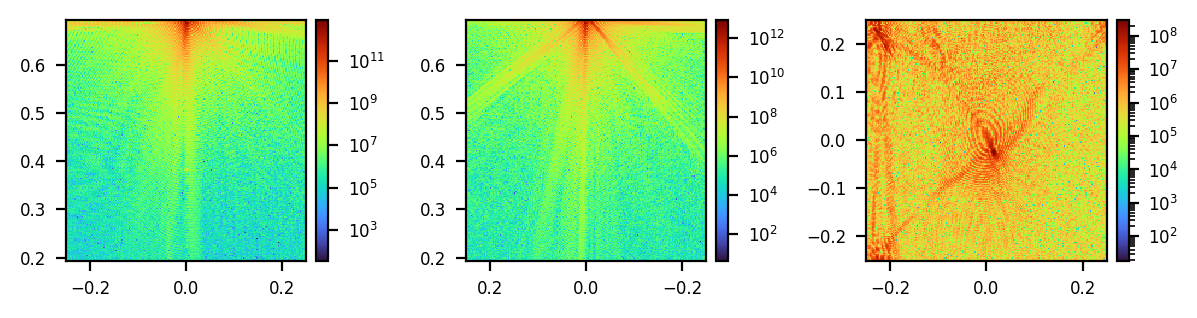

Elapsed time for the scattering computation: 806.2715916633606 s
Spatial resolution in the direct space:  0.7839195979899498 0.7839195979899498 0.7839195979899501 nm


In [10]:
lattice_parameter = 3.9
d_spacing = lattice_parameter / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)

step_nb = 800
step_nb = 400
dq = np.array([1, 1, 1]) / step_nb

q_size = (200, 200, 200)

# Let us build the reciprocal space grid
q_ranges = []
for i in range(3):
    q_ranges.append(
        (rotated_hkl[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i])
        / lattice_parameter
    )
q_grid = np.meshgrid(*q_ranges, indexing="ij")

print(f"\nStarting scattering computation for {positions.shape[1]} atoms...")
scattered_amp, dt = Fhkl_thread(
    *q_grid,
    *positions,
    occ=None,
    gpu_name="",
    language="",
    verbose=True,
)
print(f"✅ Scattering computation finished in {dt:.2f} seconds.")

diffraction_pattern = np.abs(scattered_amp)**2

cdiutils.plot.plot_volume_slices(
    diffraction_pattern,
    norm="log",
    voxel_size=(dq[0], dq[1], dq[2]),
    data_centre=[np.mean(q) for q in q_grid],
    convention="xu",
)

print(
    f"Elapsed time for the scattering computation: {dt} s\n"
    "Spatial resolution in the direct space: ",
    1 / np.ptp(q_grid[0]) * .1, 1 / np.ptp(q_grid[1]) * .1, 1 / np.ptp(q_grid[2]) * .1, "nm"
)

In [11]:
from scipy.ndimage import center_of_mass
from pynx.scattering import Fhkl_thread

# The new, fast center-of-mass function from above
def find_bragg_peak_centre_fast(diffraction_pattern: np.ndarray, q_grid: tuple) -> tuple:
    threshold = diffraction_pattern.max() * 0.1
    mask = diffraction_pattern > threshold
    indices_com = center_of_mass(diffraction_pattern, labels=mask)
    qx, qy, qz = q_grid
    # Map indices to q-space coordinates. Note the careful indexing.
    q_com = (
        qx[int(round(indices_com[0])), 0, 0],
        qy[0, int(round(indices_com[1])), 0],
        qz[0, 0, int(round(indices_com[2]))]
    )
    return q_com
find_bragg_peak_centre = find_bragg_peak_centre_fast

def refine_q_grid(
    positions: tuple,
    hkl: np.ndarray,
    lattice_parameter_guess: float,
    q_size: tuple = (200, 200, 200),
    step_nb: int = 400,
    max_iterations: int = 5,
    convert_to_angstrom: bool = True
):
    """
    Iteratively refine the q-grid to center the Bragg peak.

    Args:
        positions: atomic positions
        hkl: Miller indices
        lattice_parameter_guess: initial lattice parameter guess in
            meters. Will be converted to Angstrom if convert_to_angstrom is True.
        convert_to_angstrom: if True, converts lattice parameter to Angstrom
        q_size: size of q-grid
        step_nb: number of steps for dq calculation
        max_iterations: maximum refinement iterations

    Returns:
        tuple: (
            refined_q_grid, scattered_amp, refined_lattice_parameter
        )
    """
    unit = "m"
    rcp_space_unit = "1/m"
    if convert_to_angstrom:
        lattice_parameter_guess *= 1e10
        unit = "angstrom"
        rcp_space_unit = "1/angstrom"

    current_lattice = lattice_parameter_guess
    current_center = hkl / current_lattice

    for iteration in range(max_iterations):
        print(f"Refinement iteration {iteration + 1}/{max_iterations}")

        # build q-grid around current center
        dq = np.array([1, 1, 1]) / step_nb
        q_ranges = [current_center[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i] for i in range(3)]
        q_grid = np.meshgrid(*q_ranges, indexing="ij")

        # calculate the kinematic scattering (already optimized by the patch)
        scattered_amp, dt = Fhkl_thread(
            *q_grid, *positions, occ=None, language='', gpu_name=''
        )
        diffraction_pattern = np.abs(scattered_amp) ** 2

        # find the actual peak center using the FAST function
        peak_center = find_bragg_peak_centre_fast(diffraction_pattern, q_grid)
        
        # update center for next iteration
        shift_magnitude = np.linalg.norm(np.array(peak_center) - current_center)
        current_center = np.array(peak_center)

        # refine lattice parameter
        q_magnitude = np.linalg.norm(peak_center)
        theoretical_q = np.linalg.norm(hkl) / current_lattice
        lattice_correction = theoretical_q / q_magnitude
        current_lattice *= lattice_correction
        
        print(f"  Found peak center at: {peak_center}")
        print(f"  Refined lattice parameter: {current_lattice:.5f} {unit}")
        print(f"  Shift magnitude: {shift_magnitude:.6f} {rcp_space_unit}")
        print("-" * 50)

        # check convergence
        if shift_magnitude < (dq[0] / 2): # Converged if shift is less than half a pixel
            print("Converged!")
            break

    return q_grid, scattered_amp, current_lattice

def refine_q_grid_fast(
    positions: tuple,
    hkl: np.ndarray,
    lattice_parameter_guess: float,
    q_size: tuple = (200, 200, 200),
    step_nb: int = 400,
    max_iterations: int = 5,
    coarse_q_size: tuple = (32, 32, 32) # New parameter for the fast search
):
    """
    Iteratively refines the q-grid using a coarse-to-fine strategy for speed.
    """
    # ... (initial setup is the same)
    lattice_parameter = lattice_parameter_guess * 1e10
    current_center = hkl / lattice_parameter

    # =========================================================================
    # STAGE 1: COARSE SEARCH to find the approximate peak center quickly
    # =========================================================================
    print("--- STAGE 1: Coarse Search ---")
    print(f"Using small grid ({coarse_q_size}) to find approximate peak...")
    
    # Use a larger step size for the coarse search
    coarse_dq = np.array([1, 1, 1]) / (step_nb / (q_size[0]/coarse_q_size[0]))
    q_ranges_coarse = [current_center[i] + (np.arange(coarse_q_size[i]) - (coarse_q_size[i] / 2)) * coarse_dq[i] for i in range(3)]
    q_grid_coarse = np.meshgrid(*q_ranges_coarse, indexing="ij")

    scattered_amp_coarse, dt = Fhkl_thread(
        *q_grid_coarse, *positions, occ=None, language='', gpu_name=''
    )
    print(f"Coarse search finished in {dt:.2f} seconds.")

    diffraction_pattern_coarse = np.abs(scattered_amp_coarse) ** 2
    
    # Get the new, more accurate center from this fast search
    current_center = np.array(find_bragg_peak_centre_fast(diffraction_pattern_coarse, q_grid_coarse))
    print(f"Found approximate peak center at: {current_center}")
    
    # =========================================================================
    # STAGE 2: FINE REFINEMENT using the full-resolution grid
    # =========================================================================
    print("\n--- STAGE 2: Fine Refinement ---")
    
    # This loop should now converge in just 1-2 iterations
    for iteration in range(max_iterations):
        print(f"Fine refinement iteration {iteration + 1}/{max_iterations}")

        # Build the full-resolution q-grid, now centered on the coarse result
        dq = np.array([1, 1, 1]) / step_nb
        q_ranges = [current_center[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i] for i in range(3)]
        q_grid = np.meshgrid(*q_ranges, indexing="ij")

        scattered_amp, dt = Fhkl_thread(
            *q_grid, *positions, occ=None, language='', gpu_name=''
        )
        print(f"  Fine calculation finished in {dt:.2f} seconds.")
        
        diffraction_pattern = np.abs(scattered_amp) ** 2
        peak_center = np.array(find_bragg_peak_centre_fast(diffraction_pattern, q_grid))
        
        shift_magnitude = np.linalg.norm(peak_center - current_center)
        current_center = peak_center

        # Refine lattice parameter
        q_magnitude = np.linalg.norm(peak_center)
        theoretical_q = np.linalg.norm(hkl) / lattice_parameter
        lattice_correction = theoretical_q / q_magnitude
        lattice_parameter *= lattice_correction
        
        print(f"  Refined lattice parameter: {lattice_parameter:.5f} Angstrom")
        print(f"  Shift magnitude: {shift_magnitude:.6f} 1/Angstrom")
        print("-" * 50)

        if shift_magnitude < (dq[0] / 2):
            print("Converged!")
            break

    return q_grid, scattered_amp, lattice_parameter

def refine_q_grid_final(
    positions: np.ndarray,
    hkl: np.ndarray,
    lattice_parameter_guess: float,
    q_size: tuple = (200, 200, 200),
    step_nb: int = 400,
    max_iterations: int = 5,
    coarse_q_size: tuple = (32, 32, 32),
    coarse_natoms: int = 2_000_000  # Number of atoms for the fast coarse search
):
    """
    Refines the q-grid using atom downsampling for the coarse search and the
    full dataset for the fine refinement.
    """
    lattice_parameter = lattice_parameter_guess * 1e10
    current_center = hkl / lattice_parameter

    # =========================================================================
    # STAGE 1: COARSE SEARCH (Small Grid + Small Subset of Atoms)
    # =========================================================================
    print("--- STAGE 1: Coarse Search (using a subset of atoms) ---")
    
    # 1. Create a small, random subset of atoms
    total_atoms = positions.shape[1]
    sample_indices = np.random.choice(total_atoms, min(total_atoms, coarse_natoms), replace=False)
    positions_coarse = positions[:, sample_indices]
    print(f"Using {positions_coarse.shape[1]} random atoms for coarse search...")
    
    # 2. Build the coarse q-grid
    coarse_dq = np.array([1, 1, 1]) / (step_nb / (q_size[0] / coarse_q_size[0]))
    q_ranges_coarse = [current_center[i] + (np.arange(coarse_q_size[i]) - (coarse_q_size[i] / 2)) * coarse_dq[i] for i in range(3)]
    q_grid_coarse = [g.astype(np.float32) for g in np.meshgrid(*q_ranges_coarse, indexing="ij")]

    # 3. Run the fast calculation
    scattered_amp_coarse, dt = Fhkl_thread(
        *q_grid_coarse, *positions_coarse, occ=None, language='', gpu_name=''
    )
    print(f"Coarse search finished in {dt:.2f} seconds.")

    diffraction_pattern_coarse = np.abs(scattered_amp_coarse)**2
    current_center = np.array(find_bragg_peak_centre_fast(diffraction_pattern_coarse, q_grid_coarse))
    print(f"Found approximate peak center at: {current_center}")
    
    # =========================================================================
    # STAGE 2: FINE REFINEMENT (Full Grid + Full Dataset)
    # =========================================================================
    print("\n--- STAGE 2: Fine Refinement (using all atoms) ---")
    
    for iteration in range(max_iterations):
        print(f"Fine refinement iteration {iteration + 1}/{max_iterations}")

        # Build the full-resolution q-grid, centered on the coarse result
        dq = np.array([1, 1, 1]) / step_nb
        q_ranges = [current_center[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i] for i in range(3)]
        q_grid = [g.astype(np.float32) for g in np.meshgrid(*q_ranges, indexing="ij")]

        # Use the FULL positions array here
        scattered_amp, dt = Fhkl_thread(
            *q_grid, *positions, occ=None, language='', gpu_name=''
        )
        print(f"  Fine calculation finished in {dt:.2f} seconds.")
        
        diffraction_pattern = np.abs(scattered_amp)**2
        peak_center = np.array(find_bragg_peak_centre_fast(diffraction_pattern, q_grid))
        
        shift_magnitude = np.linalg.norm(peak_center - current_center)
        current_center = peak_center

        q_magnitude = np.linalg.norm(peak_center)
        theoretical_q = np.linalg.norm(hkl) / lattice_parameter
        lattice_correction = theoretical_q / q_magnitude
        lattice_parameter *= lattice_correction
        
        print(f"  Refined lattice parameter: {lattice_parameter:.5f} Angstrom")
        print(f"  Shift magnitude: {shift_magnitude:.6f} 1/Angstrom")
        print("-" * 50)

        if shift_magnitude < (dq[0] / 2):
            print("Converged!")
            break

    return q_grid, scattered_amp, lattice_parameter

Refinement iteration 1/10
Monkey-patch: Intercepted generic call. Forcing backend to: {'language': 'OpenCL', 'gpu_name': 'NVIDIA A40', 'cl_platform': 'NVIDIA CUDA'}
  Found peak center at: (np.float64(0.0055000000000000205), np.float64(0.012500000000000028), np.float64(0.48784969580838705))
  Refined lattice parameter: 3.54899 angstrom
  Shift magnitude: 0.923702 1/angstrom
--------------------------------------------------
Refinement iteration 2/10
Monkey-patch: Intercepted generic call. Forcing backend to: {'language': 'OpenCL', 'gpu_name': 'NVIDIA A40', 'cl_platform': 'NVIDIA CUDA'}
  Found peak center at: (np.float64(2.0816681711721685e-17), np.float64(2.7755575615628914e-17), np.float64(0.5103496958083871))
  Refined lattice parameter: 3.39385 angstrom
  Shift magnitude: 0.026320 1/angstrom
--------------------------------------------------
Refinement iteration 3/10
Monkey-patch: Intercepted generic call. Forcing backend to: {'language': 'OpenCL', 'gpu_name': 'NVIDIA A40', 'cl_pla

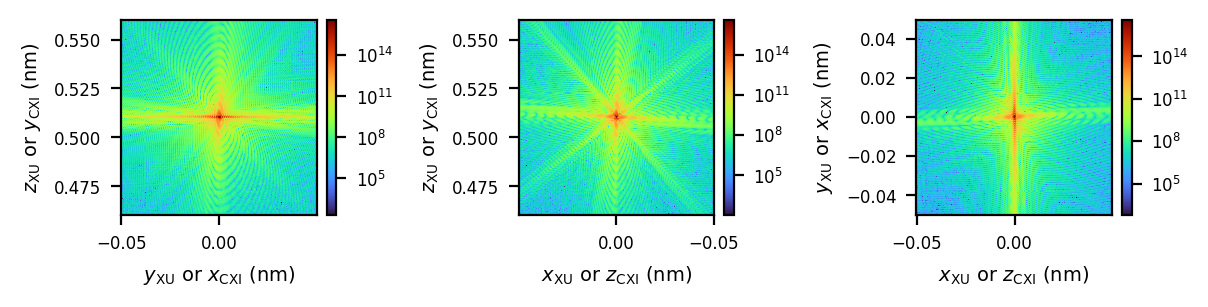

In [24]:
initial_lattice_guess = 3.92e-10  # Your initial guess
step_nb = 2000
q_size = (200, 200, 200)

# Refine the q-grid
refined_q_grid, scattered_amp, refined_lattice = refine_q_grid(
    positions, rotated_hkl, initial_lattice_guess, 
    q_size=q_size, 
    step_nb=step_nb, 
    max_iterations=10
)

print(f"Final refined lattice parameter: {refined_lattice:.4f}")

# Plot the refined result
dq = np.array([1, 1, 1]) / step_nb
fig, axes = cdiutils.plot.plot_volume_slices(
    np.abs(scattered_amp) ** 2,
    norm="log",
    voxel_size=(dq[0], dq[1], dq[2]),
    data_centre=[np.mean(q) for q in refined_q_grid],
    convention="xu",
    show=False
)
cdiutils.plot.add_labels(axes, convention="xu")
display(fig)

In [25]:
print(
    f"Elapsed time for the scattering computation: {dt} s\n"
    "Spatial resolution in the direct space: ",
    1 / np.ptp(refined_q_grid) * .1, 1 / np.ptp(refined_q_grid) * .1, 1 / np.ptp(refined_q_grid ) * .1, "nm"
)
    

Elapsed time for the scattering computation: 806.2715916633606 s
Spatial resolution in the direct space:  0.16397482967904886 0.16397482967904886 0.16397482967904886 nm


In [26]:
q_com = find_bragg_peak_centre(
    np.abs(scattered_amp)**2, refined_q_grid
)
d_spacing = 1 / np.linalg.norm(q_com)
print(
    f"d-spacing and associated lattice parameter are: {d_spacing} and "
    f"{d_spacing * np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)} A."
)

d-spacing and associated lattice parameter are: 1.9594407681893753 and 3.3938509649257886 A.


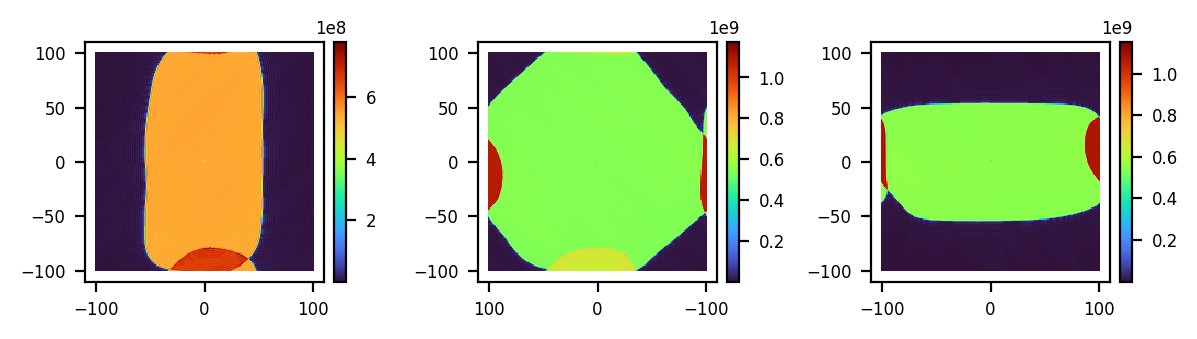

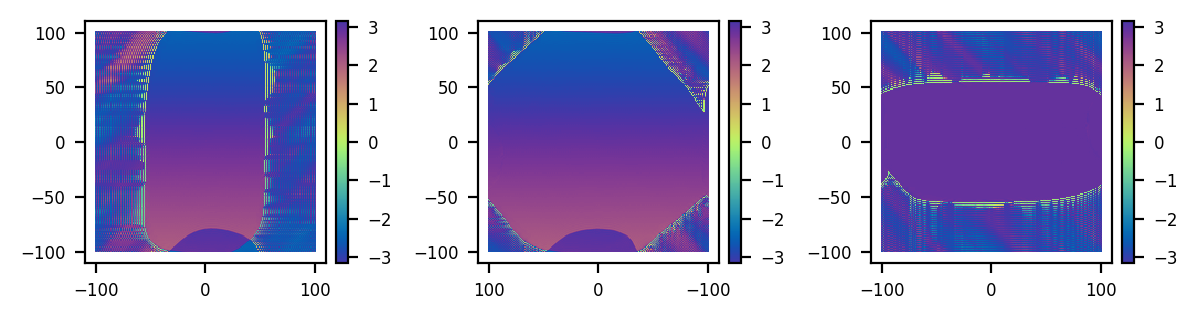

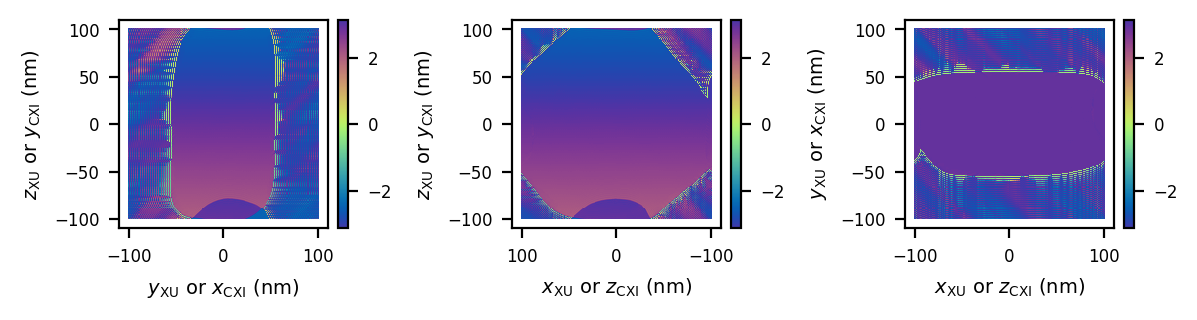

In [27]:
voxel_size = tuple(1e-1 / np.ptp(q) for q in refined_q_grid)  # in nm
obj = fftshift(fftn(ifftshift(np.conj(scattered_amp))))

support = cdiutils.utils.make_support(np.abs(obj), isosurface=0.75)
plot_params = {
    "support": support, "convention": "xu", "voxel_size": voxel_size,
    "data_centre": (0, 0, 0), "show": True,
}
# cdiutils.plot.plot_volume_slices(np.abs(obj))
cdiutils.plot.plot_volume_slices(np.abs(obj), **plot_params)
fig, axes = cdiutils.plot.plot_volume_slices(
    np.angle(obj), cmap="cet_CET_C9s_r", vmin=-np.pi, vmax=np.pi, **plot_params
)
cdiutils.plot.add_labels(axes, convention="xu")
display(fig)

In [28]:
obj = cdiutils.process.PostProcessor.apodize(obj)
struct_properties = cdiutils.process.PostProcessor.get_structural_properties(
    obj,
    isosurface=0.65,
    g_vector=tuple(q * (2*np.pi) for q in q_com),
    hkl=[1, 1, 1],
    voxel_size=voxel_size,
    phase_factor=1
)
for k in struct_properties:
    print(k)

amplitude
support
surface
phase
displacement
displacement_gradient
het_strain
het_strain_with_ramp
het_strain_from_dspacing
numpy_het_strain
dspacing
lattice_parameter
hkl
g_vector
voxel_size


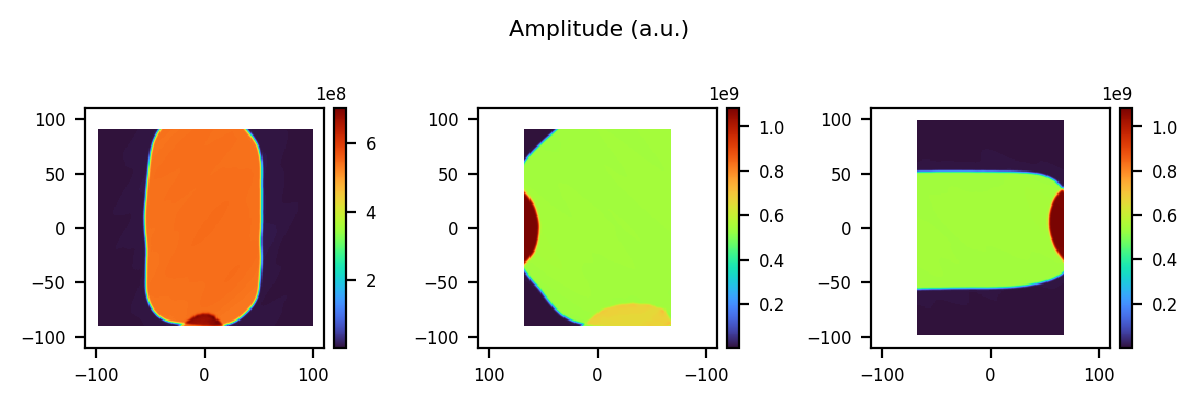

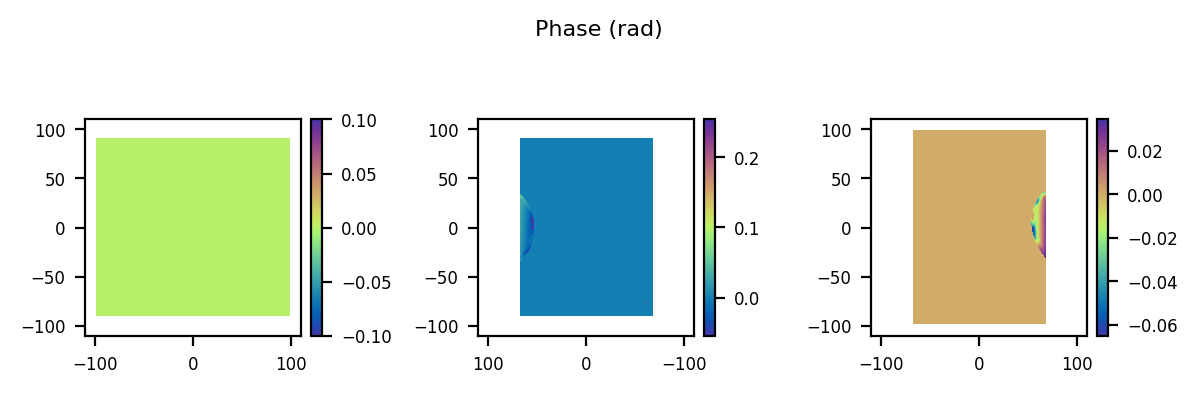

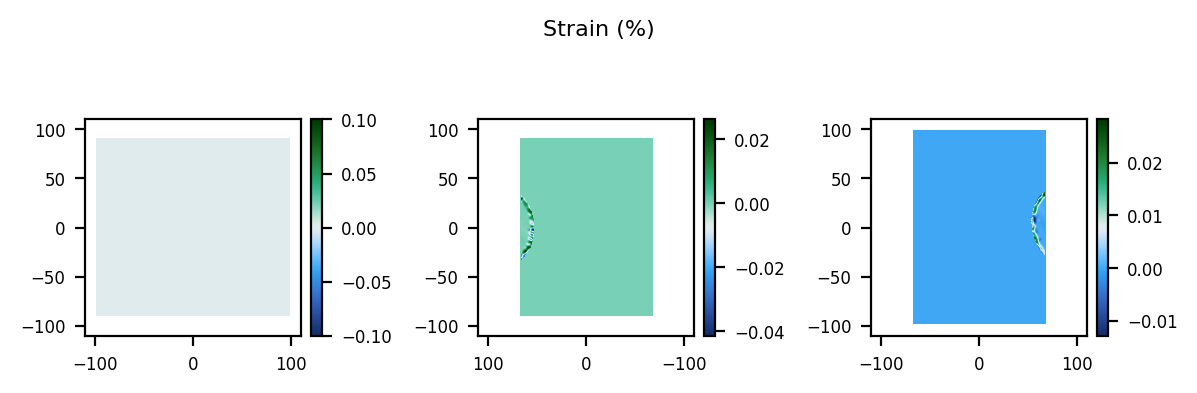

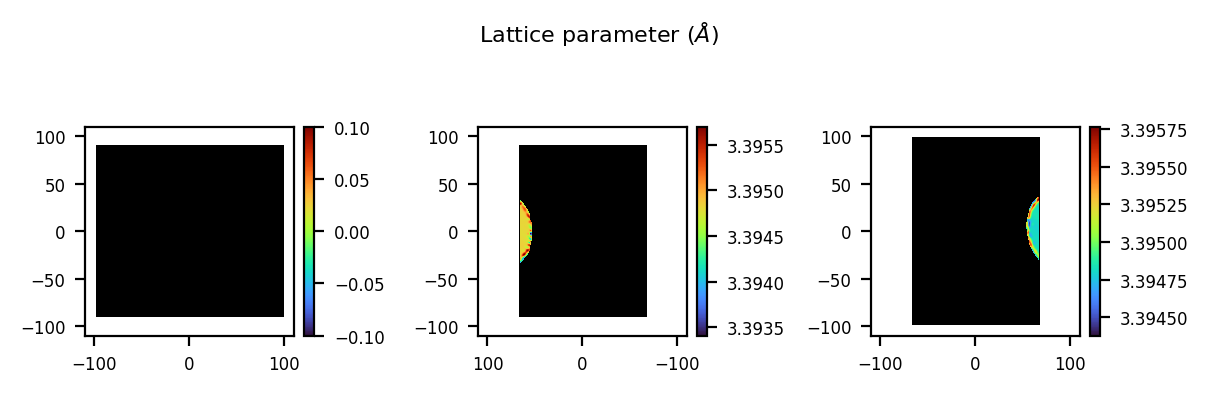

3.39481138183358


In [29]:
for k in ("amplitude", "phase", "het_strain_from_dspacing", "lattice_parameter"):
    plot_params.update(cdiutils.plot.get_plot_configs(k))
    plot_params["vmin"], plot_params["vmax"] = None, None
    cdiutils.plot.plot_volume_slices(struct_properties[k], **plot_params)

print(np.nanmean(struct_properties["lattice_parameter"]))